In [2]:
import numpy as np
import pfnet as pf
from scipy.sparse import triu,bmat,coo_matrix,eye,spdiags
import matplotlib.pyplot as plt
from scikits.sparse.cholmod import cholesky
import dill

%matplotlib inline  

In [3]:
net=pf.Network()
# net.load('PFNET-multi_period/data/ieee14.mat')
net.load('PFNET-multi_period/data/ieee300.mat')


In [4]:
penetration=50.
net.add_vargens(net.get_gen_buses(),#[net.get_bus(1)], 
                penetration, 50., 10, 0.1)

In [5]:
# Problem set up

total_load = sum([l.P for l in net.loads])
total_capacity=sum([gen.P_max for gen in net.generators])
uncertainty = 100.*sum([g.P_std for g in net.var_generators])/sum([g.P_max for g in net.var_generators])
corr_value = net.vargen_corr_value 
corr_radius = net.vargen_corr_radius

for br in net.branches:
    if br.ratingA==0:
        br.ratingA = 15

for gen in net.generators:
    gen.P_min = 0.
    gen.P_max = np.maximum(gen.P_max,0.)
    assert(gen.P_min <= gen.P_max)


num_w = net.num_buses-net.get_num_slack_buses() # voltage angles
num_p = net.get_num_P_adjust_gens()             #net.get_num_generators()         # adjustable generators
num_r = net.num_var_generators                       # renewable generators
num_bus = net.num_buses                         # buses
num_br = net.num_branches                       # branches
num_l = net.num_loads

In [6]:
# [gen.P_max for gen in net.generators]


In [7]:
# capacity_per=np.ones(5)/5
capacity_per=np.array([0.23494860499265785, 0.30279001468428781, 0.18208516886930984, 0.23906020558002939, 0.041116005873715125])
#([0.25, 0.50, 0.15, 0.05, 0.05 ])#
capacity_per_cumsum=np.cumsum(capacity_per)
sorted_gen=np.array(sorted([gen.P_max  for gen in net.generators]))
gen_cumsum=np.cumsum(sorted_gen)
gen_bounds=np.zeros(len(capacity_per)+1)
gen_bounds[0]=100
for idx,cap in enumerate(capacity_per_cumsum):
    gen_bounds[idx+1]=np.min(sorted_gen[gen_cumsum/total_capacity>=(1-cap)])
gen_bounds[-1]=0
parameters=[('Nuclear', 0.029917833750000022, 3.0741044999999803, 100, 400.0, 280.0, 280.0, 24.0, 168.0, 40000.0),
('Coal', 0.11954207142857155, 12.270104999999957, 140, 350.0, 140.0, 140.0, 5.0, 8.0, 12064.0),
('IGCC', 0.25331129032258076, 10.655729999999988, 54, 155.0, 70.0, 80.0, 16.0, 24.0, 2058.0),
('CCGT', 0.14437728426395943, 7.7242649999999946, 104, 197.0, 310.0, 310.0, 3.0, 4.0, 230.0),
('OCGT', 2.2680749999999974, 13.795700000000027, 8, 20.0, 90.0, 100.0, 1.0, 2.0, 46.0)]


In [8]:
# gen_bounds

In [9]:
# for i in range(0,len(gen_bounds)-1):
#     print np.sum([gen.P_max/total_capacity for gen in net.generators if gen.P_max>gen_bounds[i+1] and gen.P_max < gen_bounds[i] ])

In [10]:
min_down=np.zeros([num_p])
min_up=np.zeros([num_p])
ramp_up=np.zeros([num_p])
ramp_down=np.zeros([num_p])
on_off_cost=np.zeros([num_p])

gen_tech=np.chararray([num_p],itemsize=10)
for i in reversed(range(0,len(gen_bounds)-1)): 
    for gen in net.generators:
        if gen.P_max >= gen_bounds[i+1] and gen.P_max < gen_bounds[i]:
            aggregator= (np.maximum(gen.P_max/(parameters[i][4]/net.base_power),0))
#             print aggregator,parameters[i][0],gen.index
            gen.P_max= aggregator*parameters[i][4]/net.base_power
            gen.P_min= aggregator*parameters[i][3]/net.base_power
            gen.cost_coeff_Q2= net.base_power**2*parameters[i][1]/aggregator
            gen.cost_coeff_Q1= net.base_power*parameters[i][2]/aggregator
            gen.dP_max= parameters[i][5]/net.base_power*aggregator
            
            ramp_up[gen.index]=(aggregator*parameters[i][5])/net.base_power
            ramp_down[gen.index]=(aggregator*parameters[i][6])/net.base_power
            min_down[gen.index]= parameters[i][7]
            min_up[gen.index] = parameters[i][8]
            on_off_cost[gen.index] =parameters[i][9]*aggregator
            
            gen_tech[gen.index] = parameters[i][0]
            
name_techno=list(set([techno[0] for techno in parameters]))

In [11]:
# gen_tech

In [12]:
for name in name_techno:
    print (name,np.sum([ gen.P_max for idx,gen in enumerate( net.generators) if gen_tech[idx]==name ])/total_capacity)

('Nuclear', 0.24156618883370642)
('IGCC', 0.1789559383734258)
('CCGT', 0.23091681104067566)
('OCGT', 0.040026396612934501)
('Coal', 0.30853466513925776)


In [13]:
for idx, name in enumerate(name_techno):
    print sum([1 for i in range(num_p) if gen_tech[i]==name]),name

4 Nuclear
12 IGCC
28 CCGT
13 OCGT
12 Coal


In [14]:
# sorted([(gen.index , gen.P_max) for idx , gen in enumerate( net.generators)],
#        key = lambda x: float(x[1]),reverse=True)
    

In [15]:
net.clear_flags()
net.set_flags(pf.OBJ_BUS,
              pf.FLAG_VARS,
              pf.BUS_PROP_NOT_SLACK,
              pf.BUS_VAR_VANG)
net.set_flags(pf.OBJ_GEN,
              pf.FLAG_VARS,
              pf.GEN_PROP_P_ADJUST,
              pf.GEN_VAR_P)
net.set_flags(pf.OBJ_VARGEN,
              pf.FLAG_VARS,
              pf.VARGEN_PROP_ANY,
              pf.VARGEN_VAR_P)
net.set_flags(pf.OBJ_LOAD,
              pf.FLAG_VARS,
              pf.LOAD_PROP_ANY,
              pf.LOAD_VAR_P)

In [15]:
x = net.get_var_values()
Pw = net.get_var_projection(pf.OBJ_BUS,pf.BUS_VAR_VANG)
Pp = net.get_var_projection(pf.OBJ_GEN,pf.GEN_VAR_P)
Pr = net.get_var_projection(pf.OBJ_VARGEN,pf.VARGEN_VAR_P)
Pd = net.get_var_projection(pf.OBJ_LOAD,pf.LOAD_VAR_P)


In [16]:
pf_eq = pf.Constraint(pf.CONSTR_TYPE_DCPF,net)
pf_eq.analyze()
pf_eq.eval(x)
AA = pf_eq.A.copy()
bb = pf_eq.b.copy()

In [17]:
fl_lim = pf.Constraint(pf.CONSTR_TYPE_DC_FLOW_LIM,net)
fl_lim.analyze()
fl_lim.eval(x)
GG = fl_lim.G.copy()
hl = fl_lim.l.copy()
hu = fl_lim.u.copy()

In [18]:
cost = pf.Function(pf.FUNC_TYPE_GEN_COST,1.,net)
cost.analyze()
cost.eval(x)
H = (cost.Hphi + cost.Hphi.T - triu(cost.Hphi)) # symmetric
g = cost.gphi - H*x
l = net.get_var_values(pf.LOWER_LIMITS)
u = net.get_var_values(pf.UPPER_LIMITS)

In [19]:
p_max = Pp*u
p_min = Pp*l
w_max = 5*np.ones(num_w)
w_min = -5*np.ones(num_w)
r_max = Pr*u
r_base = Pr*x
z_max = hu
z_min = hl 
H0 = Pp*H*Pp.T # change costs
g0 = Pp*g
#H1 = self.H0*self.parameters['cost_factor']
g1 = np.zeros(num_p)
G = AA*Pp.T
R = AA*Pr.T
A = -AA*Pw.T
Dm = -AA*Pd.T
J = GG*Pw.T 
b = bb
ll= Pd*x #np.array([l.P for l in net.loads]) # check 

In [20]:
rr_cov = Pr*net.create_vargen_P_sigma(corr_radius,corr_value)*Pr.T
r_cov = (rr_cov+rr_cov.T-triu(rr_cov)).tocsc()
factor = cholesky(r_cov)
LL,D = factor.L_D()
P = factor.P()
PT = coo_matrix((np.ones(P.size),(P,np.arange(P.size))),shape=D.shape)
D = D.tocoo()
Dh = coo_matrix((np.sqrt(D.data),(D.row,D.col)),shape=D.shape)
L = PT*LL*Dh

In [21]:
from cvxpy import *
import mosek
import gurobi
import pickle

In [22]:
# opt_res=pickle.load( open( "deterministic_pwl.p", "rb" ) )

In [23]:
PWL=True

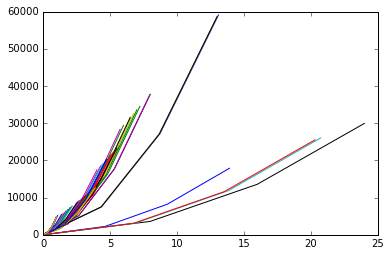

In [24]:
# PWL approximation
pwl_cost=[]
if PWL:
    pwl_points=3
    pwl_cost=np.zeros([num_p,pwl_points])
    for gen_id in range(num_p):
        xx=np.linspace(p_min[gen_id]*0,p_max[gen_id],pwl_points+1)
        y=np.zeros(pwl_points+1)
        for i in range(0,pwl_points+1):
            y[i]=0.5*H0.diagonal()[gen_id]*xx[i]**2+g0[gen_id]*xx[i]
            pwl_cost[gen_id][i-1]=((y[i]-y[i-1])/(xx[i]-xx[i-1]))
        plt.plot(xx,y)

    for gen_id in range(num_p):
        for i in range(1,pwl_points):
            assert pwl_cost[gen_id][i]>pwl_cost[gen_id][i-1]

In [25]:
norm_factor=24*num_p
H0=H0/(norm_factor)
g0=g0/(norm_factor)
pwl_cost=pwl_cost/norm_factor
on_off_cost=on_off_cost/norm_factor

In [26]:
load_data=np.genfromtxt('BPA_data/day6.csv',delimiter=',',names=True)
r_test=np.flipud(load_data['wind'])*total_load*(penetration/100)/num_r

In [27]:
np.random.seed(seed=100)
n_h=24
p=Variable(num_p,n_h)
w=Variable(num_w,n_h)
# z=Variable(num_br,n_h)
s=Variable(num_r,n_h)
load=Variable(num_l,n_h)
# on_off=Variable(num_p,n_h)

on_off=Bool(num_p,n_h)
Pforecast=total_load
Load_Penalty=np.max(pwl_cost)*2
# p_min = p_max*0.0
rampup = ramp_up #p_max/(H0.diagonal()/np.max(H0))*0.04 
rampdown=  ramp_down #p_max/(H0.diagonal()/np.max(H0))*0.04 

if PWL:
    gk=Variable(num_p*pwl_points,n_h)

theta=Variable(1)
on_off_value=np.zeros((num_p,n_h))

ontime=np.zeros(num_p)-25
on_off_init=np.zeros(num_p)

In [28]:
PWL=True

In [29]:
def eval_obj (on_off=on_off.value,p=p.value,on_off_init=on_off_init,PWL=PWL,
              on_off_cost=on_off_cost,pwl_cost=pwl_cost,H0=H0,g0=g0,
              load=load.value,b=b):
    obj_eval=0
    for i in range(1,n_h):
        obj_eval = obj_eval + np.sum(on_off_cost*np.maximum(on_off[:,i] - on_off[:,i-1],0))
    obj_eval = obj_eval + np.sum((on_off_cost)*np.maximum(on_off[:,0].T - on_off_init,0).T)

#     for i in range (n_h):
#         if PWL:
#             for j in range(pwl_points):
#                 for k in range(num_p):
#                     obj_eval=obj_eval + gk[k+(num_p*j),i]*pwl_cost[k,j]
#         else:
#             obj_eval=obj_eval + 0.5*p[:,i].T*H0*p[:,i]
#             obj_eval=obj_eval + g0*p[:,i]# check 

#         obj_eval=obj_eval + Load_Penalty*np.linalg.norm(load[:,i]-b[:,i],1)
        
    return obj_eval

def max_bend(lam,lmax=1e6):
    return np.maximum(np.minimum(lam,lmax),0.)

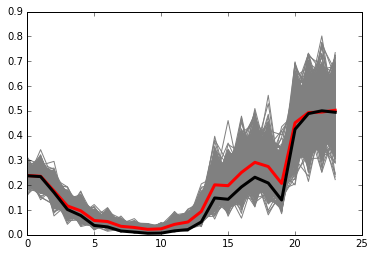

In [30]:
np.random.seed(seed=100)
mult=1.0
n_samples=100
n_test=1000
scenarios=np.zeros([n_samples+n_test,n_h])
scenarios_bus=np.zeros([num_r,n_h,n_samples+n_test])
b=[]
b=np.zeros([num_l,n_h])
for i in range (n_h):
    b[:,i]=mult*np.abs(ll)*load_data['load'][i]#/load_data['load'][0]

for j in range(n_samples+n_test):
    r=[]
    r=np.zeros([num_r,n_h])
    for i in range (n_h):
        r[:,i]=mult*np.minimum(np.maximum(r_test[i]*np.ones(num_r)
                                     +L*np.random.randn(num_r)*np.sqrt(r_test[i])*np.sqrt((i*1.+1)/(n_h)),1e-3),r_max)
    scenarios_bus[:,:,j]=r
    scenarios[j,:]=sum(r)
    plt.plot(sum(r)/total_load,color='gray')

plt.plot(np.mean(scenarios,0)/total_load,color='r',linewidth=3.0)
plt.plot(mult*r_test*num_r/total_load,color='k',linewidth=3.0)
plt.show()

In [31]:
# plt.plot(np.sum(np.mean(scenarios_bus,2),0))
# plt.plot(np.sum(r,0))
# plt.show()
# r=np.mean(scenarios_bus,2)

In [32]:
# ((rampup/p_max)/60)*100

In [33]:
def sensitivity(on_off_value,Constraints,Objective,Q_eval,n_h=n_h,p_max=p_max,p_min=p_min):
    delta_u=[]
    u_plus_delta_u=[]
    
    Constraints=list(Constraints)
    for i in range(n_h):
        delta_u.append(np.matrix(np.random.randn(num_p)).T)
        u_plus_delta_u.append(np.minimum(np.maximum(on_off_value[:,i]+delta_u[-1]/20,0),5))
        delta_u[-1]=- on_off_value[:,i] + u_plus_delta_u[-1]
        
#     zeta_du=np.sum([np.dot((Constraints[i].dual_value).T,delta_u[i])
#             +np.dot((Constraints[i+n_h].dual_value).T,delta_u[i])
#             for i in range(n_h) ])
    
    zeta_du=np.sum([-(np.diag(p_max)*Constraints[i].dual_value).T*(delta_u[i]) 
                    +(np.diag(p_min)*Constraints[i+n_h].dual_value).T*(delta_u[i])
                    for i in range(n_h) ])

    
    for i in range (n_h):
        Constraints[i]=(p[:,i]<=mul_elemwise(p_max[:],u_plus_delta_u[i]))
    for i in range (n_h):
        Constraints[i+n_h]=(p[:,i]>=mul_elemwise(p_min[:],u_plus_delta_u[i]))
        
    prob = []
    prob = Problem(Minimize(Objective), Constraints)
    Q_deltau=prob.solve(solver=GUROBI)
    
    return Q_deltau >= Q_eval + zeta_du



In [56]:
def eval_on_off(on_off_value,r,Constraints,Objective,duals=False):
    dual_multiplier_pos=np.matrix(np.zeros((n_h,num_p)))
    dual_multiplier_neg=np.matrix(np.zeros((n_h,num_p)))
    Constraints=list(Constraints)      
    for i in range (n_h):
        Constraints[i]=(p[:,i]<=mul_elemwise(p_max[:],on_off_value[:,i]))
    for i in range (n_h):
        Constraints[i+n_h]=(p[:,i]>=mul_elemwise(p_min[:],on_off_value[:,i]))
    for i in range (n_h):
        Constraints[i+2*n_h]=(s[:,i]<=r[:,i])
        
    prob = []
    prob = Problem(Minimize(Objective), Constraints)
    Q=prob.solve(solver=GUROBI)#GUROBI,BarQCPConvTol=1e-8
    
#     for i in range (2*n_h):
#         for j in range (num_p):
#             if Constraints[i].dual_value[j] <=20:
#                 Constraints[i].dual_value[j]=0
    
#     sens=np.all([sensitivity(on_off_value=on_off_value,Constraints=Constraints,Objective=Objective,Q_eval=Q_eval) 
#                  for i in range(20)])
    
    for i in range(n_h):
        dual_multiplier_pos[i,: ]= np.squeeze( np.asarray((np.diag(p_max)*Constraints[i].dual_value).T))
    for i in range(n_h):
        dual_multiplier_neg[i,: ]= np.squeeze( np.asarray((np.diag(p_min)*Constraints[i+n_h].dual_value).T))
        
    if not duals:
        return Q,p.value,load.value,s.value
    else:
        return Q, dual_multiplier_pos, dual_multiplier_neg

In [57]:
# sensitivity(on_off_value=on_off_value,Constraints=Constraints,Objective=Objective,Q_eval=Q_eval) 

In [58]:
#Benders
Q=[]
Qd=[]
T=[]
T.append(-1e9)
cost=[]
upper=[]
lower=[]
o1=[]
o2=[]
lower.append(-1e9)
tr_reg=1

# init constraints first stage
Constraints_FS=[]

# for i in range(n_h):
#     Constraints_FS.append(sum(abs(on_off[:,i]-on_off_value[:,i]))<=tr_reg)

for j in range (num_p):
    if on_off_init[j]==1:
        indi= 1
        rang= range(0,min(n_h,int(min_up[j]-ontime[j]-1)))
        if rang != []:
            Constraints_FS.append(on_off[j,rang]>=indi)
    else:
        indi= 1
        rang= range(0,min(n_h,int(min_down[j]+ontime[j]-1)))
        if rang != []:
            Constraints_FS.append(on_off[j,rang]<=1-indi)
    
for i in range(1,n_h):
    for j in range (num_p):
        indi=(on_off[j,i] - on_off[j,i-1])
        rang= range(i,min(n_h,int(i+min_up[j]-1)))
#         affected=on_off[j,rang]
#         print type(affected)
        Constraints_FS.append(on_off[j,rang]>=indi)
        
for i in range(1,n_h):
    for j in range (num_p):
        indi=(on_off[j,i-1]-on_off[j,i] )
        rang= range(i,min(n_h,int(i+min_down[j]-1)))
        if rang != []:
            Constraints_FS.append(on_off[j,rang]<=1-indi)
            
# for i in range(n_h):
#     Constraints_FS.append(on_off[:,i]<=1)
#     Constraints_FS.append(on_off[:,i]>=0)

#init objective first stage
Objective_FS=0

for i in range(1,n_h):
    Objective_FS=Objective_FS + sum(mul_elemwise(on_off_cost[:],max_elemwise(on_off[:,i] - on_off[:,i-1],0)))

Objective_FS=Objective_FS + sum(mul_elemwise(on_off_cost[:],max_elemwise(on_off[:,0] - on_off_init,0)))
Objective_FS=Objective_FS+theta  
Objective_FS=Objective_FS

# init constraints second stage

Constraints=[]
for i in range (n_h):
    Constraints.append(p[:,i]<=mul_elemwise(p_max[:],on_off_value[:,i]))
for i in range (n_h):
    Constraints.append(p[:,i]>=mul_elemwise(p_min[:],on_off_value[:,i]))
for i in range (n_h):
    Constraints.append(s[:,i]<=r[:,i])

for i in range (n_h):
    if PWL:
        for j in range (pwl_points):
            Constraints.append(gk[num_p*j:num_p*(j+1),i]<=p_max/(pwl_points))
            Constraints.append(gk[num_p*j:num_p*(j+1),i]>=0)
    
        Constraints.append( p[:,i]== np.sum ([gk[num_p*j:num_p*(j+1),i] for j in range(pwl_points)]) )
       
    Constraints.append(G*p[:,i]+R*s[:,i]-A*w[:,i]==Dm*load[:,i])
    Constraints.append(w[:,i]<=w_max)
    Constraints.append(w[:,i]>=w_min)
    Constraints.append(J*w[:,i]<=z_max)
    Constraints.append(J*w[:,i]>=z_min)
    #Changed here
    Constraints.append(s[:,i]>=0)
    Constraints.append(load[:,i]>=0)
    Constraints.append(load[:,i]<=b[:,i])
for i in range(1,n_h):
    Constraints.append(p[:,i]-p[:,i-1]<=rampup[:])
    Constraints.append(p[:,i]-p[:,i-1]>=-rampdown[:])   
    

# init objective secon stage

Objective=0
for i in range (n_h):
    if PWL:
        for j in range(pwl_points):
            for k in range(num_p):
                Objective=Objective + gk[k+(num_p*j),i]*pwl_cost[k,j]
    else:
        Objective=Objective + quad_form(p[:,i],H0*0.5)
        Objective=Objective + g0*p[:,i]# check 
        
    Objective=Objective + Load_Penalty*norm(load[:,i]-b[:,i],1)
Objective=Objective#/10

In [16]:
print installed_solvers()

NameError: name 'installed_solvers' is not defined

In [59]:
import time

In [60]:
on_off_value=np.matrix(np.zeros((num_p,n_h)))
on_off_opt=np.matrix(np.zeros((num_p,n_h)))

on_off_array=[]

Q_min=np.inf
k_opt=0
stop=0
gap=1e-1
mosek_params = {
#                  mosek.dparam.basis_tol_x: 1e-8,
                 mosek.dparam.intpnt_co_tol_dfeas:1,
                 mosek.iparam.intpnt_max_iterations: 30,
                 "MSK_IPAR_OPTIMIZER": 2.3
             }
# mosek_params={}
ini=0
final=3
eps=0#1e-2
sens=0

time_FS=[]
time_SS=[]

print "| k", "\t|", "upper", "\t\t|","lower", "\t\t|","1.Tu"

for k in range (ini,final):
    if k != 0:
        on_off_value=np.rint(on_off.value)#
        eps=0
    start_SS=time.time()
    
    for m in range(3):
        Q_value_stoch=[]
        M1_stoch=[]
        M2_stoch=[]
        Q_eval,m1,m2=eval_on_off(on_off_value,r=scenarios_bus[:,:,m],
                                 Constraints=Constraints,Objective=Objective,duals=True)
        Q_value_stoch.append(Q_eval)
        M1_stoch.append(m1)
        M2_stoch.append(m2)
    
    Q_eval=np.mean(Q_value_stoch)

    
    on_off_array.append(on_off_value)
    cost.append(eval_obj(on_off=on_off_value)+Q_eval)
    upper.append(int(np.sum(on_off_value)))
    if cost[-1]<=Q_min:
        Q_min=cost[-1]
        k_opt=k
        on_off_opt=on_off_value
    
    print "|",k,"\t|", "%.3e" % cost[-1],"\t\t|", "%.3e" % lower[-1],"\t\t|",int(np.sum(on_off_value)),"\t\t|", "%.3e" % Q_min
   
    end_SS=time.time()
    time_SS.append(end_SS-start_SS)

    if  stop==1 or cost[-1]<=lower[-1]+1:
        print "stop"
        break
    
    start_FS=time.time()
    
    m1=np.mean(M1_stoch,0)
    m2=np.mean(M2_stoch,0)
    
    benders_cut=sum([-(m1[i,:])*(on_off[:,i]-on_off_value[:,i]) 
                        +(m2[i,:])*(on_off[:,i]-on_off_value[:,i])
                        for i in range(n_h) ])

    
    alpha=1.#*(10./(k+1))

#     for i in range (n_h):
#         Constraints_FS[i]=(sum(abs(on_off[:,i]-on_off_value[:,i]))<=tr_reg)
    
    Constraints_FS.append(theta>=Q_eval+alpha*benders_cut)
    
    prob_FS = []
    prob_FS = Problem(Minimize(Objective_FS), Constraints_FS)
    F_eval=prob_FS.solve(solver=GUROBI,MIPGap=gap)
    lower.append(F_eval)
    T.append(theta.value)
    
    end_FS=time.time()
    
    time_FS.append(end_FS-start_FS)
    
#     plot=plot_bars(on_off=on_off.value)
#     plot.clear()
    
    if k==final-2:
        stop=1
    


| k 	| upper 		| lower 		| 1.Tu
| 0 	| 3.583e+04 		| -1.000e+09 		| 0 		| 3.583e+04
| 1 	| 5.713e+03 		| -3.095e+04 		| 1656 		| 5.713e+03
| 2 	| 1.040e+04 		| 2.842e+03 		| 786 		| 5.713e+03
stop


In [61]:
time_SS

[39.5978639125824, 41.28059911727905, 42.862061977386475]

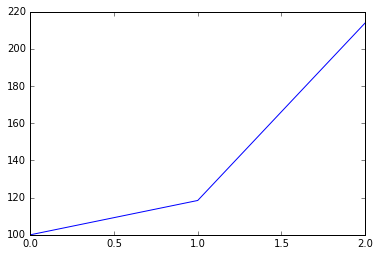

In [40]:
plt.plot(((np.array(cost)-np.array(lower))/np.abs(lower))*100)
plt.show()
# print np.min((((np.array(cost)-np.array(lower))/np.abs(lower))*100))

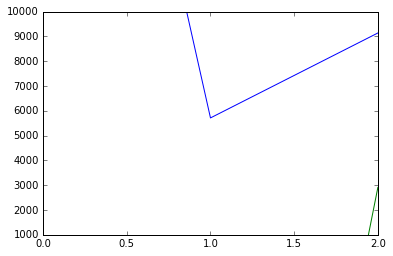

In [43]:
# optimal=2111.7#253433
plt.plot(cost[0::])
plt.plot(lower[0::])
# plt.plot(range(len(cost)),np.ones(len(cost))*(optimal))
plt.ylim(1e3,10e3)
plt.show()

In [44]:
# print (Q_min-optimal)/(optimal)*100
print np.where(cost==np.min(cost))[0]
# print np.where(np.array(cost)<=1.617e+05+1e1)[0]

[1]


In [45]:
print  k_opt, Q_min,

1 5712.84276578


In [36]:
# eval_obj(on_off=opt_res['on_off'],p=opt_res['p'],PWL=False).tolist()

In [46]:
def plot_demand(p,load,s,r,b,n_h):
    colors=['#d7191c','#fdae61','#abdda4','#2b83ba'] #['#ef8a62','#f7f7f7','#67a9cf','#008837']
    plt.figure(figsize=(10,10))
    plt.fill_between(range(n_h),np.zeros(n_h),np.squeeze(np.asarray(sum(p))),color=colors[3])
    plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(p))),
                     np.squeeze(np.asarray(sum(p)+sum(s))),
                     color=colors[1])

    plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(b))),
                     np.squeeze(np.asarray(sum(load))),
                     color=colors[0])
    plt.plot(range(n_h),np.squeeze(np.asarray(sum(b))),color='k',linewidth=3.0)
    plt.fill_between(range(n_h),np.zeros(n_h),-np.squeeze(np.asarray(np.abs(-sum(s)+sum(r)))),color=colors[2])
    plt.legend(['Demand','Generation','Renewable','Demand not served','Curtailed Renewable '],loc='best')
    plt.show()

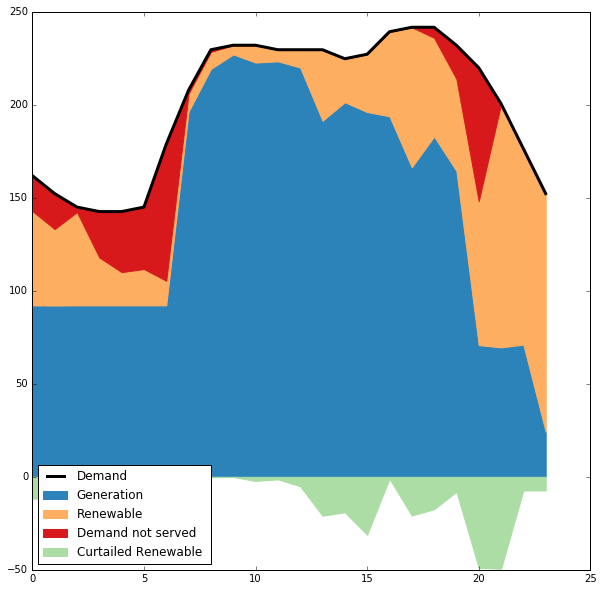

In [47]:
plot_demand(p=p.value,load=load.value,s=s.value,r=r,b=b,n_h=n_h)

In [67]:
Q_value=[]
p_value=[]
load_value=[]
s_value=[]
ocost=eval_obj(on_off=on_off_opt)
for m in range(n_samples,n_samples+n_test):
    Qaux,paux,loadaux,saux=eval_on_off(on_off_value=on_off_array[150],r=scenarios_bus[:,:,m],
                                       Constraints=Constraints,Objective=Objective)
    Q_value.append(Qaux+ocost)
    p_value.append(paux)
    load_value.append(loadaux)
    s_value.append(saux)
    

In [57]:
np.sum(on_off_array[98])

79.0

In [68]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value)

2614.54108026 4293.7023132 1946.34274491


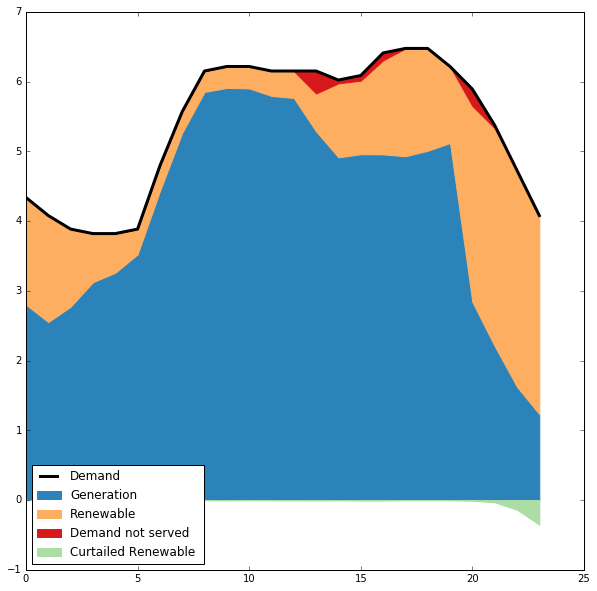

In [69]:
plot_demand(p=np.mean(p_value,0),load=np.mean(load_value,0),s=np.mean(s_value,0),r=np.mean(scenarios_bus,2),b=b,n_h=n_h)

[('Nuclear', 67.682660282530932), ('IGCC', 11.321400739425126), ('CCGT', 23.965699889654172), ('OCGT', 0.0), ('Coal', 0.0)]


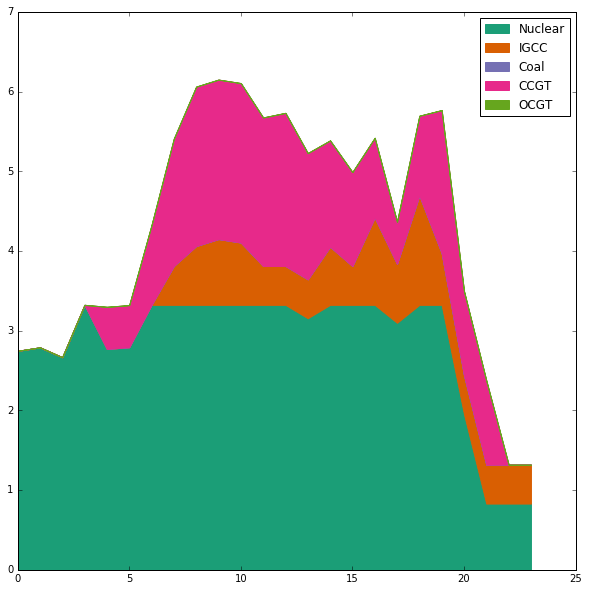

In [62]:
total_p_gen=np.sum(p.value,1)
total_share=[]

for name in name_techno:
    total_share.append((name,np.sum([ total_p_gen[i] for i in range(num_p) if gen_tech[i]==name  ])))
print total_share
# sorted_name_techno=[x[0] for x in sorted(total_share,key =lambda x: x[1],reverse=True)]
sorted_name_techno=['Nuclear','IGCC','Coal','CCGT','OCGT']
colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']#list((['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']))
share_per_hour=np.zeros([len(name_techno)+1,n_h])
plt.figure(figsize=(10,10))
for idx,name in enumerate(sorted_name_techno):
    share_per_hour[idx+1]=np.sum([ np.squeeze(np.asarray(p.value[i])) for i in range(num_p) if gen_tech[i]==name ],0)
share_per_hour=np.cumsum(share_per_hour,0)
for idx,name in enumerate(sorted_name_techno):
    plt.fill_between(range(n_h),share_per_hour[idx],share_per_hour[idx+1],color=colors[idx])
plt.legend(sorted_name_techno,loc='best')
plt.show()

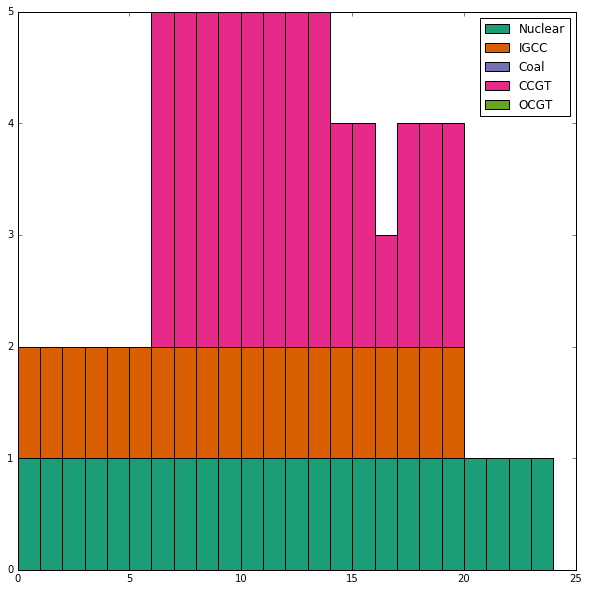

In [63]:

N = n_h
ind = np.arange(N)  # the x locations for the groups
width = 1
aux=[]
aux.append(np.zeros(N).T)
cumsum_aux=np.zeros(N)
fig, ax = plt.subplots(figsize=(10,10))
# rects = ax.bar(ind, strategy1_optMean, width, color=color[0])
for idx,name in enumerate(sorted_name_techno):
#     print name
    aux.append(np.array([np.sum(np.ceil(on_off_opt[j,i]) for j in range (num_p) if gen_tech[j]==name) for i in range(n_h)]))
    cumsum_aux=np.cumsum(aux,0)
#     print aux[-1]
    rects = ax.bar(ind, aux[idx+1], width, color=colors[idx],bottom=cumsum_aux[idx])
plt.legend(sorted_name_techno,loc='best')  
plt.show()


In [263]:
def magnanti_cut(Q_eval,p,on_off_value,p_max=p_max,p_min=p_min,n_h=n_h):
    p_value=p.value
    dual_u=Variable(num_p,2*n_h)
    Cons_dual=[]
    Cons_dual.append(np.sum([dual_u[:,i].T*((np.diag(p_max)*on_off_value[:,i])) 
                        +dual_u[:,i+n_h].T*(-(np.diag(p_min)*on_off_value[:,i]))
                        for i in range(n_h) ]) == Q_eval )
    for i in range(2*n_h):
        Cons_dual.append(dual_u[:,i]>=0)
    
    Obj_dual=0
    for i in range(n_h):
        Obj_dual=Obj_dual + sum(mul_elemwise(p_max,dual_u[:,i]))
        Obj_dual=Obj_dual + sum(mul_elemwise(p_min,dual_u[:,i+n_h]))
        
    dual_problem=[]
    dual_problem=Problem(Minimize(Obj_dual), Cons_dual)
    dual_sol=dual_problem.solve(solver=MOSEK)
    return dual_u